In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import ast
import keras
from keras import utils, layers, models, backend
import wfdb
import numpy as np
import pywt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# Глобальные переменные
# Пути и имена
_dir = 'C:/Users/gorsh/Desktop/Moving forward/Research work/' \
       'pythonProjectClass/gorshkov-bachelor-degree-project/'
_ptb_annot_file = _dir + 'ptb-xl/ptbxl_database.csv'
_ptb_diagn_file = _dir + 'ptb-xl/scp_statements.csv'
_lob_path = _dir + 'Lobachevsky data/'
_ptb_path = _dir + 'ptb-xl/'
_lob_file_names = [str(i) for i in range(1, 201)]

# Исходные данные
_Y_ptb_annot = pd.read_csv(_ptb_annot_file, index_col='ecg_id')
_Y_ptb_annot.scp_codes = _Y_ptb_annot.scp_codes.apply(lambda x: ast.literal_eval(x))
_all_diagnosis = pd.read_csv(_ptb_diagn_file, index_col=0)
# Оставляем описание только присутствующих диагнозов
_all_diagnosis = _all_diagnosis[_all_diagnosis.diagnostic == 1]

In [3]:
def aggregate_diag(y_dict, sep):
    b1 = []
    b2 = []
    for key in y_dict.keys():
        if y_dict[key] >= 80 and key in sep.index:
            b1.append(key)
            b2.append(y_dict[key])
    if len(b1) == 2:
        b1 = [b1[np.argmax(b2)]]
    return b1

_save_index_1 = ['IMI', 'ILMI', 'IPLMI', 'IPMI', 'INJIN', 'INJIL', 'AMI', 'ALMI',
                 'ASMI', 'INJAS', 'INJLA', 'INJAL', 'LMI', 'CLBBB', 'CRBBB', 
                 'ILBBB', 'IRBBB', 'IVCD', '1AVB', '3AVB', 'LAO/LAE', 'LVH', 'RAO/RAE', 'RVH']

_save_index_2 = ['IMI', 'AMI', 'CLBBB','CRBBB', 'IRBBB', '1AVB', 'LAO/LAE', 'LVH']

_save_index_3 = ['IMI', 'CLBBB','CRBBB', 'IRBBB', 'LVH', '1AVB']


_sep_diagnosis_1 = _all_diagnosis.loc[_all_diagnosis.index.isin(_save_index_1)]

_sep_diagnosis_2 = _all_diagnosis.loc[_all_diagnosis.index.isin(_save_index_2)]

_sep_diagnosis_3 = _all_diagnosis.loc[_all_diagnosis.index.isin(_save_index_3)]

# Создаём дубликаты для каждого варианта компоновки
_Y_ptb_annot_1 = _Y_ptb_annot.loc[:,['patient_id', 'report', 'scp_codes', 'filename_lr', 'filename_hr']]
_Y_ptb_annot_2 = _Y_ptb_annot.loc[:,['patient_id', 'report', 'scp_codes', 'filename_lr', 'filename_hr']]
_Y_ptb_annot_3 = _Y_ptb_annot.loc[:,['patient_id', 'report', 'scp_codes', 'filename_lr', 'filename_hr']]

# Отбираем диагнозы для каждой компоновки
_Y_ptb_annot_1['subclass'] = _Y_ptb_annot_1.scp_codes.apply(lambda x: aggregate_diag(x, _sep_diagnosis_1))
_Y_ptb_annot_2['subclass'] = _Y_ptb_annot_2.scp_codes.apply(lambda x: aggregate_diag(x, _sep_diagnosis_2))
_Y_ptb_annot_3['subclass'] = _Y_ptb_annot_3.scp_codes.apply(lambda x: aggregate_diag(x, _sep_diagnosis_3))

# Помечаем облследования без и с более одной патологиями 
_Y_ptb_annot_1['subclass'] = _Y_ptb_annot_1.subclass.apply(lambda x: x[0] if len(x) == 1 else None)
_Y_ptb_annot_2['subclass'] = _Y_ptb_annot_2.subclass.apply(lambda x: x[0] if len(x) == 1 else None)
_Y_ptb_annot_3['subclass'] = _Y_ptb_annot_3.subclass.apply(lambda x: x[0] if len(x) == 1 else None)

# Выкидываем помеченное
_Y_ptb_annot_1.drop(_Y_ptb_annot_1[_Y_ptb_annot_1.subclass.isna()].index, inplace=True)
_Y_ptb_annot_2.drop(_Y_ptb_annot_2[_Y_ptb_annot_2.subclass.isna()].index, inplace=True)
_Y_ptb_annot_3.drop(_Y_ptb_annot_3[_Y_ptb_annot_3.subclass.isna()].index, inplace=True)

# Трансляция классов
_Y_ptb_annot_1['class_'] = _Y_ptb_annot_1.subclass.apply(lambda x: _sep_diagnosis_1.loc[x, 'diagnostic_subclass'])
_Y_ptb_annot_2['class_'] = _Y_ptb_annot_2.subclass.apply(lambda x: _sep_diagnosis_2.loc[x, 'diagnostic_subclass'])
_Y_ptb_annot_3['class_'] = _Y_ptb_annot_3.subclass.apply(lambda x: _sep_diagnosis_3.loc[x, 'diagnostic_subclass'])

# Трансляция супер классов
_Y_ptb_annot_1['superclass'] = _Y_ptb_annot_1.subclass.apply(lambda x: _sep_diagnosis_1.loc[x, 'diagnostic_class'])
_Y_ptb_annot_2['superclass'] = _Y_ptb_annot_2.subclass.apply(lambda x: _sep_diagnosis_2.loc[x, 'diagnostic_class'])
_Y_ptb_annot_3['superclass'] = _Y_ptb_annot_3.subclass.apply(lambda x: _sep_diagnosis_3.loc[x, 'diagnostic_class'])

# Функция для вывода текущего состояния
def print_count(ser_1, ser_2, ser_3, text):
    print("//////////////////////")
    print(text)
    print("After the loyout annot_1")
    print(ser_1.value_counts(), '\n')
    print("After the loyout annot_2")
    print(ser_2.value_counts(), '\n')
    print("After the loyout annot_3")
    print(ser_3.value_counts())
    print("//////////////////////\n")  

print("После отбора диагнозов")
print_count(_Y_ptb_annot_1.subclass, _Y_ptb_annot_2.subclass, _Y_ptb_annot_3.subclass, 'SUBCLASS')
print_count(_Y_ptb_annot_1.class_, _Y_ptb_annot_2.class_, _Y_ptb_annot_3.class_, 'CLASS')
print_count(_Y_ptb_annot_1.superclass, _Y_ptb_annot_2.superclass, _Y_ptb_annot_3.superclass, 'SUPERCLASS')
          
          

После отбора диагнозов
//////////////////////
SUBCLASS
After the loyout annot_1
ASMI       1141
IRBBB       969
IMI         926
LVH         847
CLBBB       507
IVCD        466
CRBBB       386
1AVB        309
ILMI        252
INJAS       127
LAO/LAE      97
AMI          96
ALMI         94
RAO/RAE      49
ILBBB        45
INJAL        41
IPLMI        27
IPMI         25
LMI          22
RVH           6
3AVB          5
INJIL         4
INJIN         2
INJLA         2
Name: subclass, dtype: int64 

After the loyout annot_2
IMI        1097
IRBBB      1037
LVH        1014
CLBBB       516
CRBBB       478
1AVB        460
LAO/LAE     149
AMI          99
Name: subclass, dtype: int64 

After the loyout annot_3
IMI      1122
IRBBB    1043
LVH      1031
CLBBB     533
1AVB      490
CRBBB     486
Name: subclass, dtype: int64
//////////////////////

//////////////////////
CLASS
After the loyout annot_1
AMI        1501
IMI        1236
IRBBB       969
LVH         847
CLBBB       507
IVCD        466
CRBBB    

In [4]:
_Y_ptb_annot_1.class_.value_counts()
_Y_ptb_annot_2.class_.value_counts()
_Y_ptb_annot_3.class_.value_counts()

AMI        1501
IMI        1236
IRBBB       969
LVH         847
CLBBB       507
IVCD        466
CRBBB       386
_AVB        314
LAO/LAE      97
RAO/RAE      49
ILBBB        45
LMI          22
RVH           6
Name: class_, dtype: int64

IMI        1097
IRBBB      1037
LVH        1014
CLBBB       516
CRBBB       478
_AVB        460
LAO/LAE     149
AMI          99
Name: class_, dtype: int64

IMI      1122
IRBBB    1043
LVH      1031
CLBBB     533
_AVB      490
CRBBB     486
Name: class_, dtype: int64

In [5]:
MI_1 = ['STEMI: inferior wall.', 'STEMI: anterior wall.', 'STEMI: lateral wall.']

HYP_1 = ['Left atrial overload.', 'Left atrial hypertrophy.', 'Left ventricular hypertrophy.',
        'Right atrial hypertrophy.', 'Right atrial overload.', 'Right ventricular hypertrophy.']

CD_1 = ['Complete left bundle branch block.', 'Complete right bundle branch block.',
      'Incomplete left bundle branch block.', 'Incomplete right bundle branch block.',
      'I degree AV block','III degree AV-block.', 'Non-specific intravintricular conduction delay.']


MI_2 = ['STEMI: inferior wall.', 'STEMI: anterior wall.']

HYP_2 = ['Left atrial overload.', 'Left atrial hypertrophy.', 'Left ventricular hypertrophy.']

CD_2 = ['Complete left bundle branch block.', 'Complete right bundle branch block.',
        'Incomplete right bundle branch block.', 'I degree AV block']


MI_3 = ['STEMI: inferior wall.']

HYP_3 = ['Left ventricular hypertrophy.']

CD_3 = ['Complete left bundle branch block.', 'Complete right bundle branch block.',
        'Incomplete right bundle branch block.', 'I degree AV block']

def check_ishem(lst, MI):
    for l in lst:
        if not l in MI:
            return False
    return True

def check_cond(lst, CD):
    for l in lst:
        if not l in CD:
            return False
    return True

def check_hyp(lst, HYP):
    for l in lst:
        if not l in HYP:
            return False
    return True

_lob_list_diagn = []
for name in _lob_file_names:
    _lob_list_diagn.append(wfdb.rdrecord(_lob_path + name).comments[3:])
    
    
new_list_diagn_1 = [[] for i in range(200)]
new_list_diagn_2 = [[] for i in range(200)]
new_list_diagn_3 = [[] for i in range(200)]

# Выбираем только необходимые диагнозы
for i in range(len(_lob_list_diagn)):
    for d in _lob_list_diagn[i]:
        if d in MI_1 or d in HYP_1 or d in CD_1:
            new_list_diagn_1[i].append(d)
        if d in MI_2 or d in HYP_2 or d in CD_2:
            new_list_diagn_2[i].append(d)
        if d in MI_3 or d in HYP_3 or d in CD_3:
            new_list_diagn_3[i].append(d)
            
_Y_lob_annot_1 = pd.DataFrame({'name': [], 'diagn': []})
_Y_lob_annot_2 = pd.DataFrame({'name': [], 'diagn': []})
_Y_lob_annot_3 = pd.DataFrame({'name': [], 'diagn': []})

# Маркируем данные в соответствии с данными PTB-XL
for i in range(len(new_list_diagn_1)):
    if check_cond(new_list_diagn_1[i], CD_1):
        _Y_lob_annot_1 = _Y_lob_annot_1.append({'name': str(i + 1), 'diagn': 'CD'}, ignore_index=True)
    elif check_hyp(new_list_diagn_1[i], HYP_1):
        _Y_lob_annot_1 = _Y_lob_annot_1.append({'name': str(i + 1), 'diagn': 'HYP'}, ignore_index=True)
    elif check_ishem(new_list_diagn_1[i], MI_1):
        _Y_lob_annot_1 = _Y_lob_annot_1.append({'name': str(i + 1), 'diagn': 'MI'}, ignore_index=True)
    
for i in range(len(new_list_diagn_2)):
    if check_cond(new_list_diagn_2[i], CD_2):
        _Y_lob_annot_2 = _Y_lob_annot_2.append({'name': str(i + 1), 'diagn': 'CD'}, ignore_index=True)
    elif check_hyp(new_list_diagn_2[i], HYP_2):
        _Y_lob_annot_2 = _Y_lob_annot_2.append({'name': str(i + 1), 'diagn': 'HYP'}, ignore_index=True)
    elif check_ishem(new_list_diagn_2[i], MI_2):
        _Y_lob_annot_2 = _Y_lob_annot_2.append({'name': str(i + 1), 'diagn': 'MI'}, ignore_index=True)
        
for i in range(len(new_list_diagn_3)):
    if check_cond(new_list_diagn_3[i], CD_3):
        _Y_lob_annot_3 = _Y_lob_annot_3.append({'name': str(i + 1), 'diagn': 'CD'}, ignore_index=True)
    elif check_hyp(new_list_diagn_3[i], HYP_3):
        _Y_lob_annot_3 = _Y_lob_annot_3.append({'name': str(i + 1), 'diagn': 'HYP'}, ignore_index=True)
    elif check_ishem(new_list_diagn_3[i], MI_3):
        _Y_lob_annot_3 = _Y_lob_annot_3.append({'name': str(i + 1), 'diagn': 'MI'}, ignore_index=True)

print("После отбора диагнозов")
print_count(_Y_lob_annot_1.diagn, _Y_lob_annot_2.diagn, _Y_lob_annot_3.diagn, 'SUPERCLASS')

После отбора диагнозов
//////////////////////
SUPERCLASS
After the loyout annot_1
HYP    97
CD     57
MI      1
Name: diagn, dtype: int64 

After the loyout annot_2
HYP    100
CD      66
MI       1
Name: diagn, dtype: int64 

After the loyout annot_3
CD     92
HYP    91
Name: diagn, dtype: int64
//////////////////////



In [6]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path + f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# Загружаем отведения PTB-XL
_X_ptb_lead_1 = load_raw_data(_Y_ptb_annot_1, 500, _ptb_path)
_X_ptb_lead_2 = load_raw_data(_Y_ptb_annot_2, 500, _ptb_path)
_X_ptb_lead_3 = load_raw_data(_Y_ptb_annot_3, 500, _ptb_path)

# Загружаем отведения LUDB
_X_lob_lead_1 = np.array([wfdb.rdsamp(_lob_path + f)[0] for f in _Y_lob_annot_1.name])
_X_lob_lead_2 = np.array([wfdb.rdsamp(_lob_path + f)[0] for f in _Y_lob_annot_2.name])
_X_lob_lead_3 = np.array([wfdb.rdsamp(_lob_path + f)[0] for f in _Y_lob_annot_3.name])

In [7]:
# Обрезаем 

# 1/4 секунды
_indent = 125

def cut(data, indent):
    buf = np.zeros((data.shape[0], data.shape[1] - 2 * indent, data.shape[2]))
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            buf[i,:,j] = data[i, indent: -indent, j]
    return buf


_X_ptb_lead_cut_1 = cut(_X_ptb_lead_1, _indent)
_X_ptb_lead_cut_2 = cut(_X_ptb_lead_2, _indent)
_X_ptb_lead_cut_3 = cut(_X_ptb_lead_3, _indent)


_X_lob_lead_cut_1 = cut(_X_lob_lead_1, _indent)
_X_lob_lead_cut_2 = cut(_X_lob_lead_2, _indent)
_X_lob_lead_cut_3 = cut(_X_lob_lead_3, _indent)


In [8]:
_X_ptb_lead_cut_1.shape

(6445, 4750, 12)

In [9]:
# Понижение размерности
def lowering_dimension(data, wavelet, level):
    size = pywt.wavedec(data[0, :, 0], wavelet, level=level)[0].shape[0]
    buf = np.zeros((data.shape[0], size, 12))
    for m in range(data.shape[0]):
        for v in range(data.shape[2]):
            buf[m, :, v] = pywt.wavedec(data[m, :, v], wavelet, level=level)[0].T
    return buf
            
_X_ptb_lead_low_1 = lowering_dimension(_X_ptb_lead_cut_1, 'db4', 4)
_X_ptb_lead_low_2 = lowering_dimension(_X_ptb_lead_cut_2, 'db4', 4)
_X_ptb_lead_low_3 = lowering_dimension(_X_ptb_lead_cut_3, 'db4', 4)

_X_lob_lead_low_1 = lowering_dimension(_X_lob_lead_cut_1, 'db4', 4)
_X_lob_lead_low_2 = lowering_dimension(_X_lob_lead_cut_2, 'db4', 4)
_X_lob_lead_low_3 = lowering_dimension(_X_lob_lead_cut_3, 'db4', 4)

In [10]:
_X_ptb_lead_low_3.shape

(4705, 303, 12)

In [11]:
##### Очистка от выбросов

# Поиск выбросов и выбрасывание
def clear_trash(data1, y1, count):
    data = data1.copy()
    y = y1.copy()
    y.reset_index(inplace=True)
    
    drop_list = []
    # Получаем стандартное отклонение по каждому отведению в каждом обследовании
    std = data.std(axis=(1))
    for i in range(data.shape[0]):
        if is_out(data[i], std[i], count):
            drop_list.append(i)
    
    print('long of drop list: ', len(drop_list))
    data = np.delete(data, drop_list, axis=0)
    y.drop(index=drop_list, inplace=True)
    return data, y, drop_list

# Проверка на наличие выбросов
def is_out(data, std, count):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if -count * abs(std[j]) > data[i, j] or count * abs(std[j]) < data[i, j]:
                return True
    return False

# Количество сигм, для оценки выбросов
count_sigm = 7
_X_ptb_lead_clear_1, _Y_ptb_annot_clear_1, _ = clear_trash(_X_ptb_lead_low_1, _Y_ptb_annot_1, count_sigm)
_X_ptb_lead_clear_2, _Y_ptb_annot_clear_2, _ = clear_trash(_X_ptb_lead_low_2, _Y_ptb_annot_2, count_sigm)
_X_ptb_lead_clear_3, _Y_ptb_annot_clear_3, dr_lst_ptb = clear_trash(_X_ptb_lead_low_3, _Y_ptb_annot_3, count_sigm)
        
_X_lob_lead_clear_1, _Y_lob_annot_clear_1, _ = clear_trash(_X_lob_lead_low_1, _Y_lob_annot_1, count_sigm)
_X_lob_lead_clear_2, _Y_lob_annot_clear_2, _ = clear_trash(_X_lob_lead_low_2, _Y_lob_annot_2, count_sigm)
_X_lob_lead_clear_3, _Y_lob_annot_clear_3, dr_lst_lob = clear_trash(_X_lob_lead_low_3, _Y_lob_annot_3, count_sigm)

long of drop list:  427
long of drop list:  348
long of drop list:  334
long of drop list:  7
long of drop list:  7
long of drop list:  7


In [12]:
_X_ptb_lead_clear_1.shape
_X_ptb_lead_clear_2.shape
_X_ptb_lead_clear_3.shape
 
_X_lob_lead_clear_1.shape
_X_lob_lead_clear_2.shape
_X_lob_lead_clear_3.shape

(6018, 303, 12)

(4502, 303, 12)

(4371, 303, 12)

(148, 303, 12)

(160, 303, 12)

(176, 303, 12)

In [13]:
_Y_ptb_annot_clear_1.subclass.value_counts()
_Y_ptb_annot_clear_2.subclass.value_counts()
_Y_ptb_annot_clear_3.subclass.value_counts()

ASMI       1075
IRBBB       927
IMI         834
LVH         780
CLBBB       468
IVCD        446
CRBBB       368
1AVB        292
ILMI        226
INJAS       120
LAO/LAE      89
ALMI         89
AMI          88
RAO/RAE      47
ILBBB        42
INJAL        38
IPLMI        25
IPMI         24
LMI          21
RVH           6
3AVB          5
INJIL         4
INJIN         2
INJLA         2
Name: subclass, dtype: int64

IMI        995
IRBBB      990
LVH        931
CLBBB      476
CRBBB      452
1AVB       433
LAO/LAE    134
AMI         91
Name: subclass, dtype: int64

IMI      1017
IRBBB     995
LVH       948
CLBBB     492
1AVB      460
CRBBB     459
Name: subclass, dtype: int64

In [35]:
#Нужно просто поменять фунцию!!

# Стандартизация
def standartization(data):
    _std = data.std(axis=(1))
    _mean = data.mean(axis=(1))
    stand = np.zeros_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            stand[i, :, j] = (data[i, :, j] - _mean[i, j]) / _std[i, j]
    return stand

# _X_ptb_lead_standart_1 = standartization(_X_lob_lead_clear_1)
# _X_ptb_lead_standart_2 = standartization(_X_lob_lead_clear_2)


# Масштабирование
def scaling(data):
    _min = data.min(axis=(1))
    _max = data.max(axis=(1))
    scale = np.zeros_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            scale[i, :, j] = (data[i, :, j] - _min[i, j]) / (_max[i, j] - _min[i, j])
    return scale

_X_ptb_lead_scal_1 = scaling(_X_ptb_lead_clear_1)
_X_ptb_lead_scal_2 = scaling(_X_ptb_lead_clear_2)
_X_ptb_lead_scal_3 = scaling(_X_ptb_lead_clear_3)

_X_lob_lead_scal_1 = scaling(_X_lob_lead_clear_1)
_X_lob_lead_scal_2 = scaling(_X_lob_lead_clear_2)
_X_lob_lead_scal_3 = scaling(_X_lob_lead_clear_3)

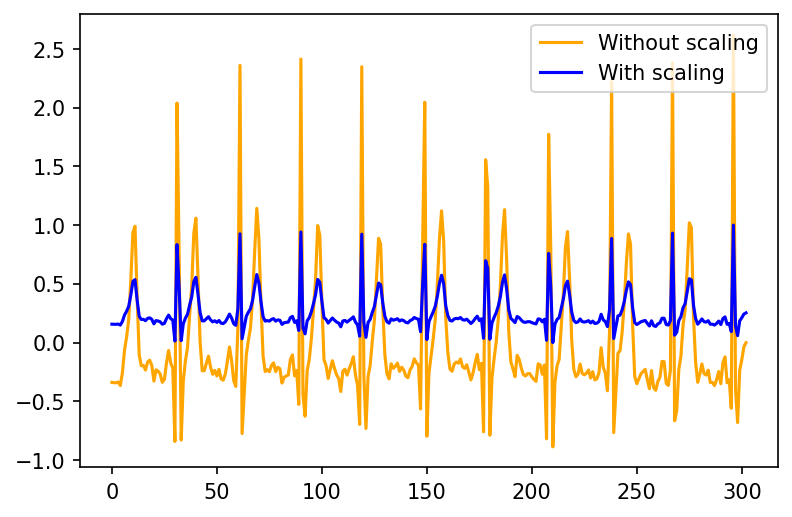

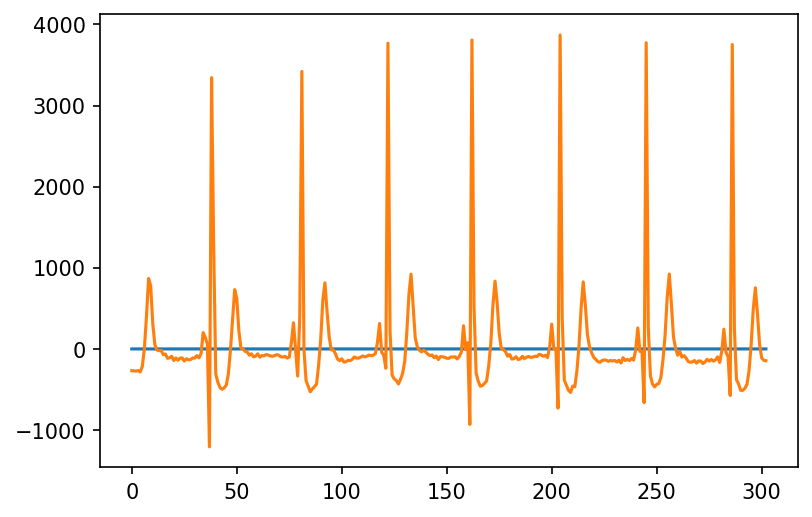

In [37]:
fig, ax  = plt.subplots(dpi=150)
ax.plot(range(303), _X_ptb_lead_clear_1[0,:,0], color='orange');
ax.plot(range(303), _X_ptb_lead_scal_1[0,:,0], color='blue');
plt.legend(['Without scaling', 'With scaling'], loc='upper right')
# plt.legend(['With standardization', 'Without standardization'], loc='upper right') 

fig, ax  = plt.subplots(dpi=150)

ax.plot(range(303), _X_lob_lead_scal_1[0,:,0]);
ax.plot(range(303), _X_lob_lead_clear_1[0,:,0]);

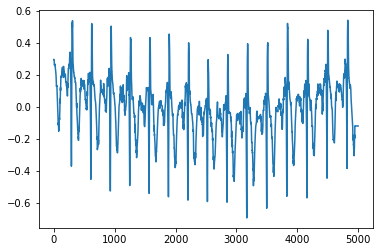

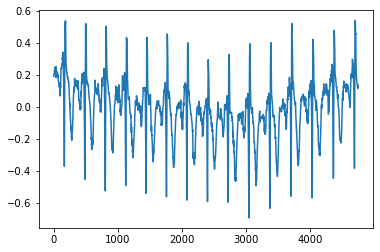

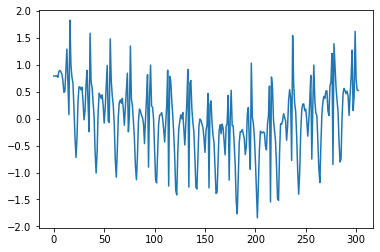

In [602]:
plt.plot(range(5000), _X_ptb_lead_1[1,:,3]);
plt.show()
plt.plot(range(4750), _X_ptb_lead_cut_1[1,:,3]);
plt.show()
plt.plot(range(303), _X_ptb_lead_clear_1[1,:,3]);

In [15]:
_X_lob_lead_scal_1.shape
_X_ptb_lead_scal_2.shape
_X_ptb_lead_scal_3.shape

(148, 303, 12)

(4502, 303, 12)

(4371, 303, 12)

In [16]:
# Получение вейвлет-спектра

def make_CWT(data, w):
    widths = np.arange(1, w + 1)
    CWT = np.zeros((data.shape[0], w, data.shape[1]))
    for ind in range(data.shape[0]):
        CWT[ind] = pywt.cwt(data[ind], widths, 'mexh')[0]
    return CWT

_X_ptb_vect_1 = _X_ptb_lead_scal_1.reshape(_X_ptb_lead_scal_1.shape[0], -1)
_X_ptb_vect_2 = _X_ptb_lead_scal_2.reshape(_X_ptb_lead_scal_2.shape[0], -1)
_X_ptb_vect_3 = _X_ptb_lead_scal_3.reshape(_X_ptb_lead_scal_3.shape[0], -1)
_X_lob_vect_1 = _X_lob_lead_scal_1.reshape(_X_lob_lead_scal_1.shape[0], -1)
_X_lob_vect_2 = _X_lob_lead_scal_2.reshape(_X_lob_lead_scal_2.shape[0], -1)
_X_lob_vect_3 = _X_lob_lead_scal_3.reshape(_X_lob_lead_scal_3.shape[0], -1)

_X_ptb_cwt_1 = make_CWT(_X_ptb_vect_1, 20)
_X_ptb_cwt_2 = make_CWT(_X_ptb_vect_2, 20)
_X_ptb_cwt_3 = make_CWT(_X_ptb_vect_3, 20)
_X_lob_cwt_1 = make_CWT(_X_ptb_vect_1, 20)
_X_lob_cwt_2 = make_CWT(_X_ptb_vect_2, 20)
_X_lob_cwt_3 = make_CWT(_X_ptb_vect_3, 20)

In [17]:
_X_ptb_cwt_1.shape
_X_ptb_cwt_2.shape
_X_ptb_cwt_3.shape
_X_lob_cwt_1.shape
_X_lob_cwt_2.shape
_X_lob_cwt_3.shape

(6018, 20, 3636)

(4502, 20, 3636)

(4371, 20, 3636)

(6018, 20, 3636)

(4502, 20, 3636)

(4371, 20, 3636)

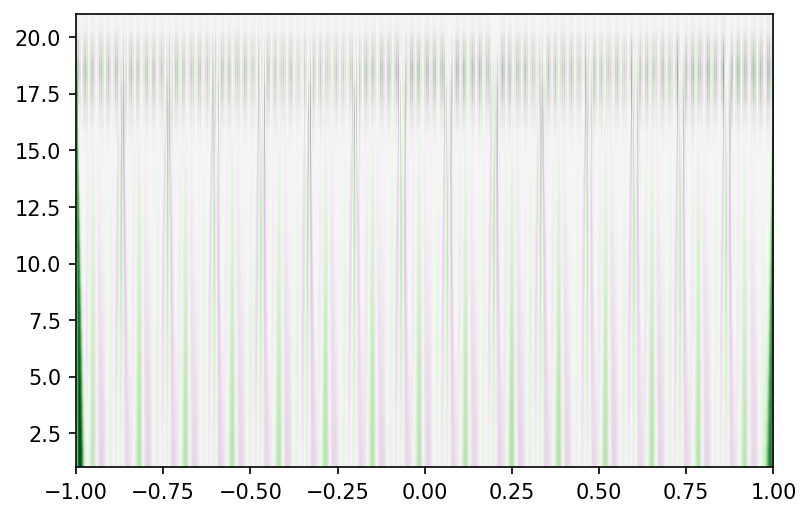

In [145]:
el = 10
plt.figure(dpi=150)
plt.imshow(_X_ptb_cwt_1[el], extent=[-1, 1, 1, 21], cmap='PRGn', aspect='auto', \
    vmax=abs(_X_ptb_cwt_1[el]).max(), vmin=-abs(_X_ptb_cwt_1[el]).max());

In [18]:
#Кодируем и бинаризуем метки
_oh_enc = OneHotEncoder(sparse=False)
_le_enc = LabelEncoder()

_Y_ptb_1 = _Y_ptb_annot_clear_1.superclass.to_numpy()
_Y_ptb_le_1 = _le_enc.fit_transform(_Y_ptb_1)
_Y_ptb_oh_1 = _oh_enc.fit_transform(_Y_ptb_le_1.reshape(-1,1))
print(_le_enc.classes_)
_Y_ptb_2 = _Y_ptb_annot_clear_2.superclass.to_numpy()
_Y_ptb_le_2 = _le_enc.transform(_Y_ptb_2)
_Y_ptb_oh_2 = _oh_enc.transform(_Y_ptb_le_2.reshape(-1,1))

_Y_ptb_3 = _Y_ptb_annot_clear_3.superclass.to_numpy()
_Y_ptb_le_3 = _le_enc.fit_transform(_Y_ptb_3)
_Y_ptb_oh_3 = _oh_enc.fit_transform(_Y_ptb_le_3.reshape(-1,1))

_Y_val_1 = _Y_lob_annot_clear_1.diagn.to_numpy()
_Y_val_le_1 = _le_enc.transform(_Y_val_1)
_Y_val_oh_1 = _oh_enc.transform(_Y_val_le_1.reshape(-1,1))

_Y_val_2 = _Y_lob_annot_clear_2.diagn.to_numpy()
_Y_val_le_2 = _le_enc.transform(_Y_val_2)
_Y_val_oh_2 = _oh_enc.transform(_Y_val_le_2.reshape(-1,1))

_Y_val_3 = _Y_lob_annot_clear_3.diagn.to_numpy()
_Y_val_le_3 = _le_enc.transform(_Y_val_3)
_Y_val_oh_3 = _oh_enc.transform(_Y_val_le_3.reshape(-1,1))




# Разделение на обучение и тест
_X_train_1, _X_test_1, _Y_train_1, _Y_test_1 = train_test_split(
    _X_ptb_cwt_1,
    _Y_ptb_oh_1,
    test_size=0.3,
    random_state=4323
)
_X_train_2, _X_test_2, _Y_train_2, _Y_test_2 = train_test_split(
    _X_ptb_cwt_2,
    _Y_ptb_oh_2,
    test_size=0.3,
    random_state=76434
)
_X_train_3, _X_test_3, _Y_train_3, _Y_test_3 = train_test_split(
    _X_ptb_cwt_3,
    _Y_ptb_oh_3,
    test_size=0.3,
    random_state=4532
)

['CD' 'HYP' 'MI']


In [19]:
_Y_ptb_oh_1.shape
_X_ptb_cwt_1.shape

(6018, 3)

(6018, 20, 3636)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 20, 3636, 4)       404       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 1818, 4)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 1818, 8)       808       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 909, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 909, 16)        3216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 454, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 454, 32)        1

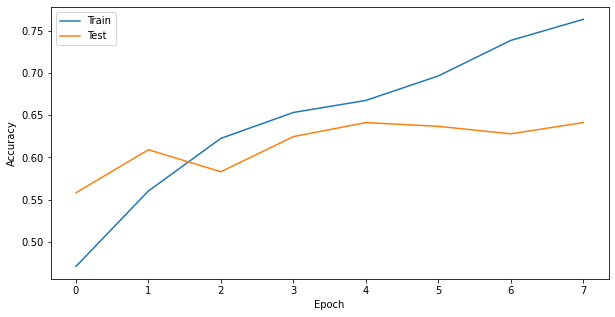

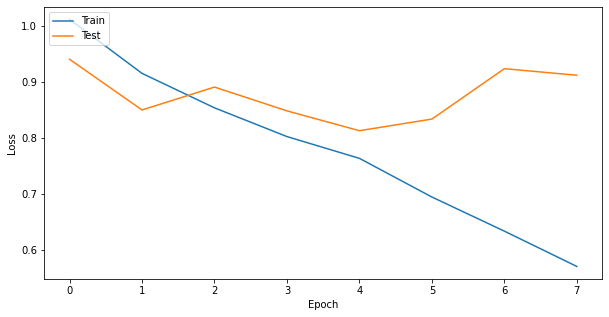

C:\Users\gorsh\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


NameError: name 'X_test' is not defined

In [20]:
# Модель для двумерного входа
def fit_model_2d(x_train, x_test, y_train, y_test, x_val, y_val):
    backend.clear_session()
    _model = models.Sequential()
    _model.add(layers.Conv2D(filters=4, kernel_size=10, strides=1, padding='same', 
        input_shape=(x_train.shape[1], x_train.shape[2], 1)
    ))
    _model.add(layers.MaxPool2D())
    _model.add(layers.Conv2D(filters=8, kernel_size=5, strides=1, padding='same'))
    _model.add(layers.MaxPool2D())
    _model.add(layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same'))
    _model.add(layers.MaxPool2D())
    _model.add(layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same'))
    _model.add(layers.MaxPool2D())
    _model.add(layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same'))
    _model.add(layers.Flatten())
#     _model.add(layers.Dense(128, activation='relu'))
#     _model.add(layers.Dropout(0.5))
    _model.add(layers.Dense(64, activation='relu'))
    _model.add(layers.Dropout(0.5))
    _model.add(layers.Dense(3, activation='softmax'))

    print(_model.summary())
    _model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    _history = _model.fit(
        x_train[:, :, :, np.newaxis],
        y_train,
        batch_size=32,
        epochs=8,
        validation_data=(x_test[:, :, :, np.newaxis], y_test))
    
     
    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(_history.history['accuracy'])
    plt.plot(_history.history['val_accuracy'])
    plt.legend('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 5))
    plt.plot(_history.history['loss'])
    plt.plot(_history.history['val_loss'])
    plt.legend('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    CNN_estimator_y_pred_val = _model.predict_classes(x_val[:, :, :, np.newaxis])
    CNN_estimator_y_pred_test = _model.predict_classes(X_test[:, :, :, np.newaxis])

    print('Validate')
    print(classification_report(y_val, CNN_estimator_y_pred_val))

    print('Test')
    print(classification_report(y_test, CNN_estimator_y_pred_test))
    
    return _model
    
fit_model_2d(_X_train_1, _X_test_1, _Y_train_1, _Y_test_1, _X_lob_cwt_1, _Y_val_le_1)

In [ ]:
# Модель для одномерного входа
def fit_model_1d(x_train, x_test, y_train, y_test):
    backend.clear_session()
    _model = models.Sequential()
    _model.add(layers.Conv2D(filters=8, kernel_size=5, strides=1, padding='same', 
        input_shape=(x_train.shape[1], x_train.shape[2], 1)
    ))
    _model.add(layers.MaxPool1D())
    _model.add(layers.Conv1D(filters=8, kernel_size=5, strides=1, padding='same'))
    _model.add(layers.MaxPool1D())
    _model.add(layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='same'))
    _model.add(layers.MaxPool1D())
    _model.add(layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='same'))
    _model.add(layers.MaxPool1D())
    _model.add(layers.Conv1D(filters=64, kernel_size=5, strides=1, padding='same'))
    _model.add(layers.MaxPool1D())
    _model.add(layers.Conv1D(filters=128, kernel_size=5, strides=1, padding='same'))
    _model.add(layers.MaxPool1D())
    _model.add(layers.Dense(128, activation='relu'))
    _model.add(layers.Dropout(0.5))
    _model.add(layers.Dense(64, activation='relu'))
    _model.add(layers.Dropout(0.3))
    _model.add(layers.Dense(3, activation='softmax'))

    print(_model.summary())
    _model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    _history = _model.fit(
        x_train[:, :, :, np.newaxis],
        y_train,
        batch_size=32,
        epochs=10,
        validation_data=(x_test[:, :, :, np.newaxis], y_test))

    
fit_model(_X_train_1, _X_test_1, _Y_train_1, _Y_test_1)